In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [2]:
%matplotlib notebook

In [3]:
# meta data
z = 0.00888
tb_max = 58863.9

In [4]:
lc_df = pd.read_hdf('/Users/adamamiller/astronomy/ZTF/SN19yvq/data/P48/SN2019yvq/data/photometry/P48/forcephot_product/lightcurves/ZTF19adcecwu_force_phot_nob.h5')

In [5]:
fcqfid = lc_df.fieldid.values*10000 + lc_df.ccdid.values*100 + lc_df.qid.values*10 + lc_df.filterid

lc_df['fcqfid'] = fcqfid
lc_df.to_hdf('../data/P48/ZTF19adcecwu_force_phot_nob.h5', 'd1')

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->bytes,key->block1_values] [items->['filter', 'diffimgname', 'psfimgname']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [6]:
np.unique(fcqfid[-300:])

array([8191341., 8191342., 8191343., 8201641., 8201642., 8201643.])

In [9]:
t_data, f_data, f_unc_data, fcqfid_data = prep_light_curve('../data/P48/ZTF19adcecwu_force_phot_nob.h5', 
                 t_max=tb_max+2400000.5, z=z,
                 g_max = 1.2087067164884248e-06, 
                 r_max = 1.472898868390068e-06)

<IPython.core.display.Javascript object>


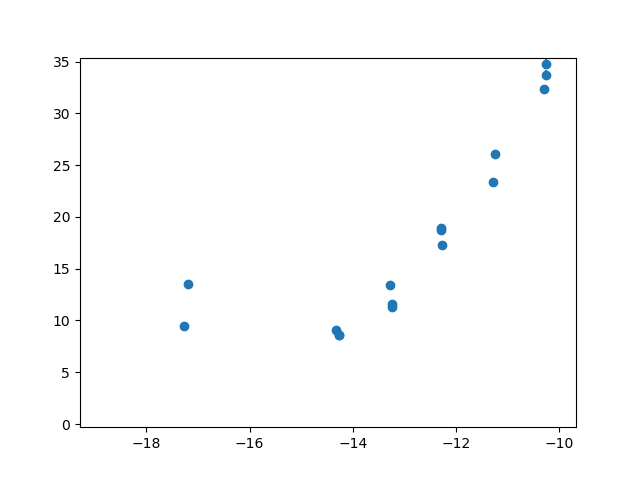

<ErrorbarContainer object of 3 artists>

In [10]:
plt.figure()
plt.errorbar(t_data, f_data, f_unc_data, fmt='o')

In [12]:
len(t_data[mask_bump])

1147

In [13]:
t_data

array([-761.59955386, -639.0001692 , -638.9927697 , ...,  -10.29747046,
        -10.25868299,  -10.25775375])

In [15]:
mask_bump = np.where((t_data < -30) | (t_data > -15.5))

prep_df = pd.DataFrame(data=t_data[mask_bump], columns=['t_data'])
prep_df['f_data'] = f_data[mask_bump]
prep_df['f_unc_data'] = f_unc_data[mask_bump]
prep_df['fcqfid_data'] = fcqfid_data[mask_bump]

In [17]:
prep_df.to_hdf('first_light_2019yvq.h5', 'd1')

In [8]:
def prep_light_curve(lc_hdf,
                     t_max=0, 
                     z=0,
                     g_max=1,
                     r_max=1,
                     rel_flux_cutoff=0.4, 
                     flux_scale = 100,
                     return_masked=False,
                     return_post_disc=False):
    
    # light curve data
    lc_df = pd.read_hdf(lc_hdf)
    
    lc_df.drop(np.where((lc_df.fcqfid.values == 8202592) | 
                        (lc_df.fcqfid.values == 8191343) |
                       (lc_df.fcqfid.values == 8201643))[0], inplace=True)

    time_rf = (lc_df['jdobs'].values - t_max)/(1+z)        
    baseline = np.where(time_rf < -20)
    has_baseline = np.ones_like(time_rf).astype(bool)
    fmcmc = lc_df['Fmcmc'].values
    fmcmc_unc = lc_df['Fmcmc_unc'].values
    zp = lc_df.zp.values
    zp_unc = lc_df.ezp.values
    
    f_zp = np.zeros_like(fmcmc)
    f_zp_unc = np.zeros_like(fmcmc)
    zp_base = np.zeros_like(fmcmc)
    
    for fcqfid in np.unique(lc_df.fcqfid.values):
        this_chip = np.where(lc_df.fcqfid.values == fcqfid)
        this_baseline = np.intersect1d(baseline, this_chip)
        if len(this_baseline) >= 1:
            zp_base[this_chip] = np.median(fmcmc[this_baseline]/10**(0.4*zp[this_baseline]))

            f_zp[this_chip] = fmcmc[this_chip]/10**(0.4*zp[this_chip])
            f_zp_unc[this_chip] = np.hypot(fmcmc_unc[this_chip]/10**(0.4*zp[this_chip]), 
                                             np.log(10)/2.5*fmcmc[this_chip]*zp_unc[this_chip]/10**(0.4*zp[this_chip]))
        else:
            has_baseline[this_chip] = 0
            
    g_obs = np.where((lc_df['filter'] == b'g') & (has_baseline))
    r_obs = np.where((lc_df['filter'] == b'r') & (has_baseline))

    f_zp[g_obs] = f_zp[g_obs]/g_max
    f_zp[r_obs] = f_zp[r_obs]/r_max
    f_zp_unc[g_obs] = f_zp_unc[g_obs]/g_max
    f_zp_unc[r_obs] = f_zp_unc[r_obs]/r_max
    
    new_night = np.append(np.where(np.diff(lc_df['jdobs'].values[has_baseline]) >= 0.6), 
                          len(lc_df['jdobs'].values[has_baseline])-1)

    mean_rf = np.zeros_like(new_night).astype(float)
    mean_g = np.zeros_like(new_night).astype(float)
    mean_r = np.zeros_like(new_night).astype(float)
    for nnumber, nidx in enumerate(new_night + 1):
        if nnumber == 0:
            start_idx = 0
        else:
            start_idx = new_night[nnumber-1] + 1
        end_idx = nidx


        jd_tonight = lc_df['jdobs'].values[has_baseline][start_idx:end_idx]
        fcqfid_tonight = lc_df.fcqfid.values[has_baseline][start_idx:end_idx]
        f_zp_tonight = f_zp[start_idx:end_idx]
        f_zp_unc_tonight = f_zp_unc[start_idx:end_idx]
        zp_base_tonight = zp_base[start_idx:end_idx]

        g_tonight = np.array(fcqfid_tonight % 2).astype(bool)

        mean_rf[nnumber] = np.mean((jd_tonight - t_max)/(1+z))
        if sum(g_tonight) > 0:
            mean_g[nnumber] = np.average(f_zp_tonight[g_tonight] - zp_base_tonight[g_tonight]/g_max, 
                                         weights=f_zp_unc_tonight[g_tonight]**(-2))
        if sum(g_tonight)/len(g_tonight) < 1:
            mean_r[nnumber] = np.average(f_zp_tonight[~g_tonight] - zp_base_tonight[~g_tonight]/r_max, 
                                         weights=f_zp_unc_tonight[~g_tonight]**(-2))

    cutoff_g = np.where((mean_rf < 0) & (mean_g > 0) & 
                       (mean_g < rel_flux_cutoff))
    t_cut_g = mean_rf[cutoff_g[0][-1]] + 0.5
    early_g = np.where(time_rf[g_obs] < t_cut_g)
    cutoff_r = np.where((mean_rf < 0) & (mean_r > 0) & 
                       (mean_r < rel_flux_cutoff))
    t_cut_r = mean_rf[cutoff_r[0][-1]] + 0.5
    early_r = np.where(time_rf[r_obs] < t_cut_r)
    early_obs = np.append(g_obs[0][early_g], r_obs[0][early_r])

    return_obs = np.intersect1d(np.where(has_baseline > 0), early_obs)
    not_included = np.setdiff1d(range(len(f_zp)), return_obs)    


    if return_masked:
        return time_rf, f_zp*flux_scale, f_zp_unc*flux_scale, lc_df.fcqfid.values, return_obs
    elif return_post_disc:
        # only grab obs after initial detection
        initial_snr = (lc_df.Fmcmc.values - lc_df.offset.values)/(lc_df.Fmcmc_unc.values*lc_df['multiply'].values)
        first_det = np.where(initial_snr >= 5)[0][0]
        post_disc = np.where(lc_df.jdobs.values >= lc_df.jdobs.iloc[first_det] + 0.6)
        early_post_disc = np.intersect1d(early_obs, post_disc)
        
        return time_rf[early_post_disc], f_zp[early_post_disc]*flux_scale, f_zp_unc[early_post_disc]*flux_scale, lc_df.fcqfid.values[early_post_disc]
    else:
        return time_rf[return_obs], f_zp[return_obs]*flux_scale, f_zp_unc[return_obs]*flux_scale, lc_df.fcqfid.values[return_obs]